In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
from scipy.io import loadmat
from sklearn.utils import shuffle
from datetime import datetime

In [21]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [22]:
def error_rate(p, t):
    return np.mean(p != t)

In [23]:
def flatten(X):
    # input will be (32, 32, 3, N)
    # output will be (N, 3072)
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat

In [24]:
def main():
    train = loadmat('../large_files/train_32x32.mat')
    test  = loadmat('../large_files/test_32x32.mat')

    # Need to scale! don't leave as 0..255
    # Y is a N x 1 matrix with values 1..10 (MATLAB indexes by 1)
    # So flatten it and make it 0..9
    # Also need indicator matrix for cost calculation
    Xtrain = flatten(train['X'].astype(np.float32) / 255)
    Ytrain = train['y'].flatten() - 1
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    Ytrain_ind = y2indicator(Ytrain)

    Xtest  = flatten(test['X'].astype(np.float32) / 255)
    Ytest  = test['y'].flatten() - 1
    Ytest_ind  = y2indicator(Ytest)

    # gradient descent params
    max_iter = 20
    print_period = 10
    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = int(N / batch_sz)

    # initial weights
    M1 = 1000 # hidden layer size
    M2 = 500
    K = 10
    W1_init = np.random.randn(D, M1) / np.sqrt(D + M1)
    b1_init = np.zeros(M1)
    W2_init = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    b2_init = np.zeros(M2)
    W3_init = np.random.randn(M2, K) / np.sqrt(M2 + K)
    b3_init = np.zeros(K)

    # define variables and expressions
    X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    T = tf.placeholder(tf.float32, shape=(None, K), name='T')
    W1 = tf.Variable(W1_init.astype(np.float32))
    b1 = tf.Variable(b1_init.astype(np.float32))
    W2 = tf.Variable(W2_init.astype(np.float32))
    b2 = tf.Variable(b2_init.astype(np.float32))
    W3 = tf.Variable(W3_init.astype(np.float32))
    b3 = tf.Variable(b3_init.astype(np.float32))

    Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
    Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
    Yish = tf.matmul(Z2, W3) + b3

    cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = Yish, labels=T))

    train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

    # we'll use this to calculate the error rate
    predict_op = tf.argmax(Yish, 1)

    t0 = datetime.now()
    LL = []
    init = tf.initialize_all_variables()
    with tf.Session() as session:
        session.run(init)

        for i in range(max_iter):
            for j in range(n_batches):
                Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                    prediction = session.run(predict_op, feed_dict={X: Xtest})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)
    print("Elapsed time:", (datetime.now() - t0))
    plt.plot(LL)
    plt.show()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Cost / err at iteration i=0, j=0: 58381.055 / 0.804
Cost / err at iteration i=0, j=10: 58211.055 / 0.804
Cost / err at iteration i=0, j=20: 58259.340 / 0.804
Cost / err at iteration i=0, j=30: 58089.059 / 0.804
Cost / err at iteration i=0, j=40: 57728.656 / 0.804
Cost / err at iteration i=0, j=50: 57391.516 / 0.803
Cost / err at iteration i=0, j=60: 56818.902 / 0.803
Cost / err at iteration i=0, j=70: 55593.824 / 0.749
Cost / err at iteration i=0, j=80: 54530.648 / 0.748
Cost / err at iteration i=0, j=90: 55822.102 / 0.769
Cost / err at iteration i=0, j=100: 53228.488 / 0.707
Cost / err at iteration i=0, j=110: 50720.688 / 0.659
Cost / err at iteration i=0, j=120: 48096.348 / 0.650
Cost / err at iteration i=0, j=130: 47841.461 / 0.646
Cost / err at iteration i=0, j=140: 42758.094 / 0.570
Cost / err at iteration i=1, j=0: 44441.750 / 0.583
Cost / err at iteration i=1, j=10: 40406.758 / 0.491
Cost / err at iteratio

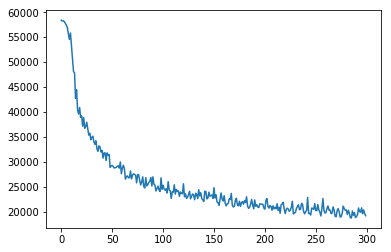

In [25]:
if __name__ == '__main__':
    main()